In [34]:
from numpy import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, ks_2samp

mean = np.array([-5, 5])
cov = 5 * np.eye(2)

x = np.linspace(-15, 15, 100)  
y = np.linspace(-15, 15, 100)

X, Y = np.meshgrid(x, y)


Calculating the Score Function: Larger values indicate regions where small changes in 
x lead to large changes in probability.

In [35]:
def score_function(mean, variance, x): # check this 
    mean = mean.reshape(-1, 1) if mean.ndim == 1 else mean
    return -(x - mean) / variance

In [36]:
def draw_guassian_dist(X, Y, Z):
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(label='Probability Density')
    plt.title('2D Gaussian Distribution')
    plt.show()

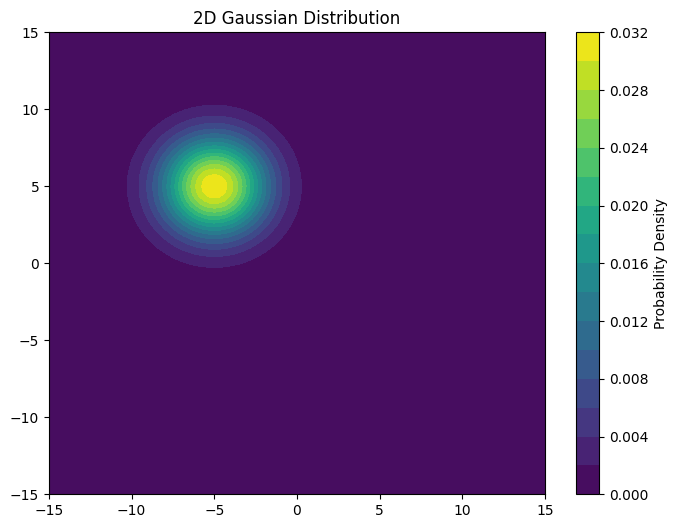

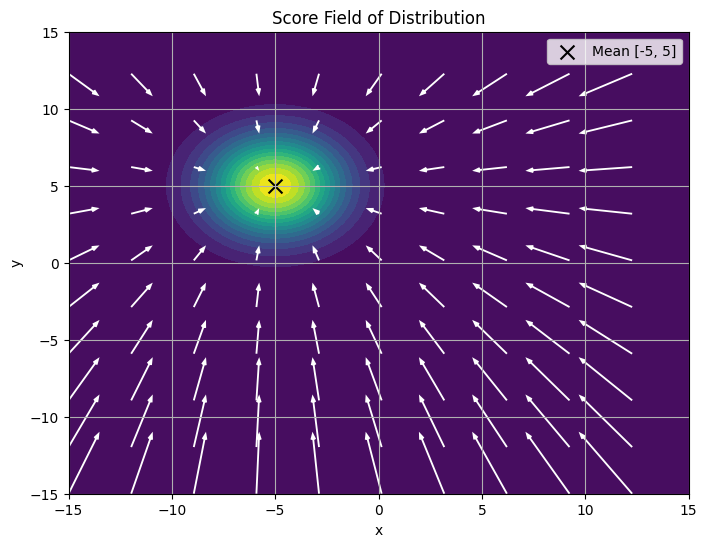

In [37]:
def gen_quiver_plot(X, Y, Z):
    step = 10
    X_sub = X[::step, ::step]
    Y_sub = Y[::step, ::step]
    
    points_arr = np.vstack([X_sub.ravel(), Y_sub.ravel()])
    
    variance = 5
    scores = score_function(mean, variance, points_arr)
    i = scores[0].reshape(X_sub.shape)
    j = scores[1].reshape(Y_sub.shape)
    
    plt.figure(figsize = (8, 6))
    
    plt.contourf(X, Y, Z, levels = 20, cmap = 'viridis')
    plt.quiver(X_sub, Y_sub, i, j,
               color = 'white', scale = 40, width = 0.003, 
               headwidth = 3, headlength = 4)
    plt.scatter(mean[0], mean[1], c = 'black', s = 100, label = 'Mean [-5, 5]', marker = 'x')
    plt.xlim(-15, 15)
    plt.ylim(-15, 15)
    plt.title("Score Field of Distribution")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
pos = np.dstack((X, Y))
rv = multivariate_normal(mean, cov)
Z = rv.pdf(pos)

draw_guassian_dist(X, Y, Z)
gen_quiver_plot(X, Y, Z)

In [50]:
def plot_trajectories(trajectories, X, Y, Z):
    plt.figure(figsize = (8, 6))
    plt.contourf(X, Y, Z, cmap = 'viridis', levels = 20, alpha = 0.3)
    
    for i in range(min(20, trajectories.shape[1])):
        plt.plot(trajectories[:, i, 0], trajectories[:, i, 1], 
                'r-', alpha = 0.5, lw = 0.5, solid_capstyle = 'round')
    
    
    plt.scatter(trajectories[0, :20, 0], trajectories[0, :20, 1], 
               c = 'blue', s = 20, label = 'Initial Points')
    plt.scatter(trajectories[-1, :20, 0], trajectories[-1, :20, 1], 
               c = 'red', s = 20, label = 'Final Samples')
    
    plt.scatter(mean[0], mean[1], c = 'black', s = 100, marker = '*', 
                label = 'Mean', edgecolor = 'white')
    plt.title('Sampling Trajectories')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.xlim(-15, 15)
    plt.ylim(-15, 15)
    plt.show()



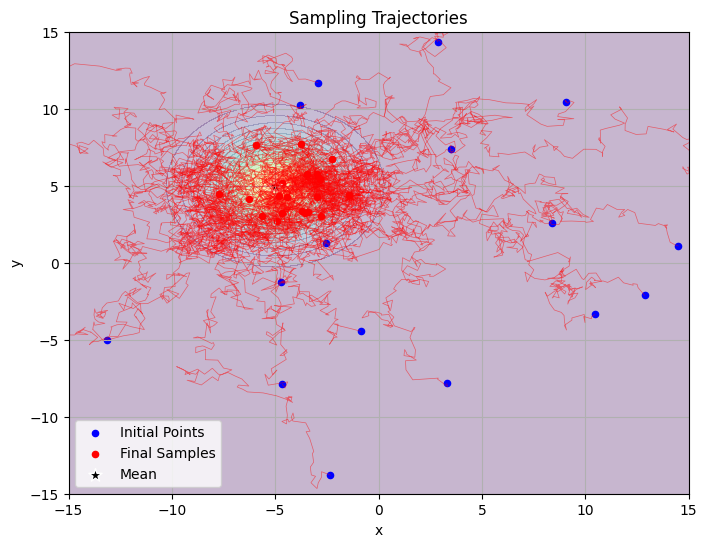

In [51]:
def langevin_sampling(initial_points, num_iters = 1000, learning_rate = 0.01):
    samples = initial_points.copy()
    trajectory = [samples.copy()]
    
    for _ in range(num_iters):
        scores = score_function(mean, 5, samples.T, )
        scores = scores.T
        
        noise = np.random.randn(*samples.shape)
        samples = samples + learning_rate * scores + np.sqrt(learning_rate * 2) * noise
        trajectory.append(samples.copy())
        
    return samples, np.array(trajectory)

initial_points = random.randn(100, 2) * 10
final_samples, trajectories = langevin_sampling(
    initial_points,
    num_iters = 500,
    learning_rate = 0.05
    )  
  
plot_trajectories(trajectories, X, Y, Z)

In [40]:
def choose_samples_with_function():
    mean = np.array([-5, 5])
    cov = 5 * np.eye(2)
    samples = np.random.multivariate_normal(mean, cov, size = 1000)
    return samples

In [41]:
def compare_langevin_mv(mv_samples, ld_samples):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.scatter(mv_samples[:, 0], mv_samples[:, 1], alpha=0.5)
    ax1.set_title('Samples from Numpy')
    ax2.scatter(ld_samples[:, 0], ld_samples[:, 1], alpha=0.5)
    ax2.set_title('Langevin Dynamics')
    
    for ax in (ax1, ax2):
        ax.scatter(-5, 5, c='red', marker='x', s=100)
        ax.set_xlim(-15, 5)
        ax.set_ylim(-5, 15)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('x₁')
        ax.set_ylabel('x₂')
    
    plt.tight_layout()
    plt.show()

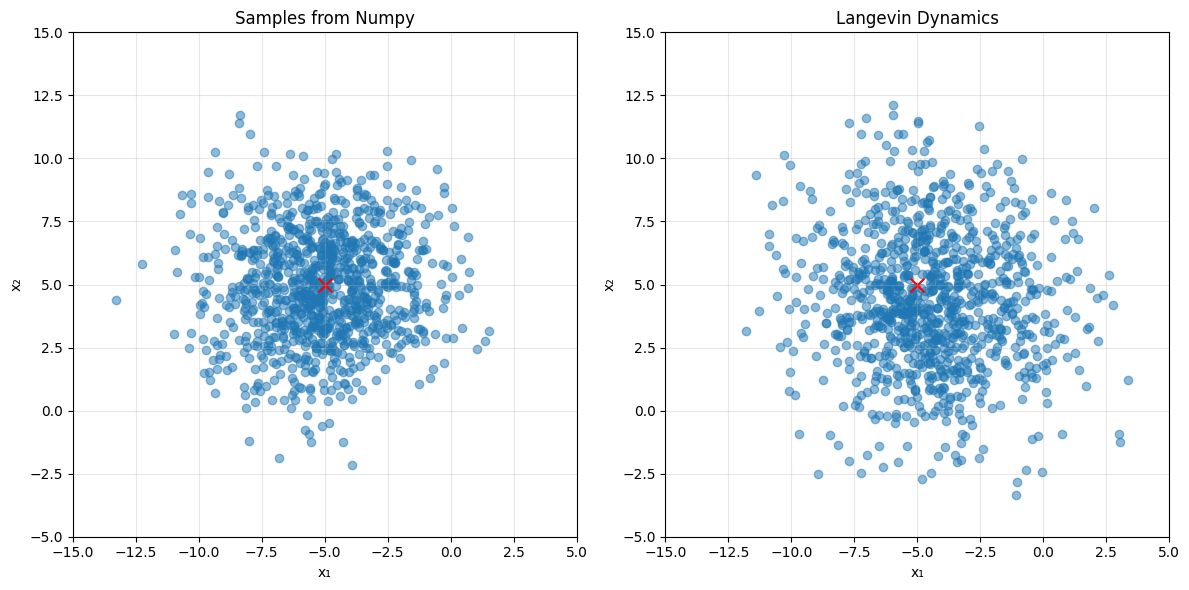

In [42]:
mv_samples = mv_samples = choose_samples_with_function()
ld_samples, _ = langevin_sampling(np.random.randn(1000, 2)*10)
compare_langevin_mv(mv_samples, ld_samples)

In [43]:
def compare_mean(mv_samples, ld_samples):
    mv_mean = np.mean(mv_samples, axis = 0)
    ld_mean = np.mean(ld_samples, axis = 0)
    return mv_mean, ld_mean

In [44]:
def compare_cov(mv_samples, ld_samples):
    mv_cov = np.cov(mv_samples.T)
    ld_cov = np.cov(ld_samples.T)
    return mv_cov, ld_cov
    
    

In [45]:
def compare_metrics():
    mv_mean, ld_mean = compare_mean(mv_samples, ld_samples)
    mv_cov, ld_cov = compare_cov(mv_samples, ld_samples)
    stats_data = [
        ["Mean (x₁, x₂)", f"{mv_mean.round(2)}", f"{ld_mean.round(2)}"],
        ["Covariance (diag)", f"{mv_cov.diagonal().round(2)}", f"{ld_cov.diagonal().round(2)}"],
        ["KS Test p-value (x₁)", "-", f"{ks_2samp(mv_samples[:,0], ld_samples[:,0]).pvalue:.15f}"], 
        ["KS Test p-value (x₂)", "-", f"{ks_2samp(mv_samples[:,1], ld_samples[:,1]).pvalue:.15f}"]
    ]
    
    for stat in stats_data:
        print(stat)
    
compare_metrics()

['Mean (x₁, x₂)', '[-5.15  4.93]', '[-4.44  4.37]']
['Covariance (diag)', '[5.18 4.82]', '[6.51 7.22]']
['KS Test p-value (x₁)', '-', '0.000000030427400']
['KS Test p-value (x₂)', '-', '0.000001084530345']
